Parts of this assignment will be **automatically graded**. Please take note of the following:
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- You can add additional cells, but it is not recommended to (re)move cells. Cells required for autograding cannot be moved and cells containing tests cannot be edited.
- You are allowed to use a service such as [Google Colaboratory](https://colab.research.google.com/) to work together. However, you **cannot** hand in the notebook that was hosted on Google Colaboratory, but you need to copy your answers into the original notebook and verify that it runs succesfully offline. This is because Google Colaboratory destroys the metadata required for grading.
- Name your notebook **exactly** `{TA_name}_{student1_id}_{student2_id}_lab{i}.ipynb`, for example `wouter_12345_67890_lab1.ipynb` (or tim|elise|david|qi, depending on your TA), **otherwise your submission will be skipped by our regex and you will get 0 points** (but no penalty as we cannot parse your student ids ;)).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names below:

In [ ]:
NAMES = "Philipp Lintl, Bogdan Floris"

---

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

---
## 1. Policy Evaluation (1 point)

In this exercise we will evaluate a policy, e.g. find the value function for a policy. The problem we consider is the gridworld from Example 4.1 in the book. The environment is implemented as `GridworldEnv`, which is a subclass of the `Env` class from [OpenAI Gym](https://github.com/openai/gym). This means that we can interact with the environment. We can look at the documentation to see how we can interact with the environment.

In [11]:
from gridworld import GridworldEnv
env = GridworldEnv()
# Lets see what this is
?env

In [3]:
# To have a quick look into the code
??env

Now we want to evaluate a policy by using Dynamic Programming. For more information, see the [Intro to RL](https://drive.google.com/open?id=1opPSz5AZ_kVa1uWOdOiveNiBFiEOHjkG) book, section 4.1. This algorithm requires knowledge of the problem dynamics in the form of the transition probabilities $p(s',r|s,a)$. In general these are not available, but for our gridworld we know the dynamics and these can be accessed as `env.P`.

In [13]:
# Take a moment to figure out what P represents. 
# Note that this is a deterministic environment. 
# What would a stochastic environment look like?

## For each state: {action: [(probability, nextstate, reward, done)]}
env.P

{0: {0: [(1.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True)],
  2: [(1.0, 0, 0.0, True)],
  3: [(1.0, 0, 0.0, True)]},
 1: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 2, -1.0, False)],
  2: [(1.0, 5, -1.0, False)],
  3: [(1.0, 0, -1.0, True)]},
 2: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 6, -1.0, False)],
  3: [(1.0, 1, -1.0, False)]},
 3: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 7, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 4: {0: [(1.0, 0, -1.0, True)],
  1: [(1.0, 5, -1.0, False)],
  2: [(1.0, 8, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 5: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 6, -1.0, False)],
  2: [(1.0, 9, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 6: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 10, -1.0, False)],
  3: [(1.0, 5, -1.0, False)]},
 7: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 11, -1.0, False)],
  3: [(1.0, 6, -1.0, False)]},
 8: {0: [(1.0, 4

In [19]:
 def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluates a policy and computes its state values given an environment
    and a full description of that environment (an Markov Decision Process).
    The environment should be a subclass from the OpenAI Gym environments.
    :param env: The OpenAI Gym environment:
                 - env.P - transition probabilities of the environment
                 - env.P[state][action] - a list of transition tuples
                 - env.observation_space.n - number of states
                 - env.action_space.n - number of actions
    :param policy: the policy to be evaluated (if None, initialize an equidistant policy)
    :param discount_factor: gamma the discount factor
    :param theta: we stop iterating once the state value changes are less than theta
    :return: the state values computes
    """
    if policy is None:
        raise ValueError('No policy to evaluate')
    # initialize the state values
    state_values =   np.zeros(env.nS)
    # initialize delta check
    delta = theta + 1.0
    while delta > theta:
        delta = 0
        # loop over all the states
        for state in env.P.keys():
            value = state_values[state]
            state_values[state] = 0.0
            # loop over all the actions
            for action, action_prob in zip(env.P[state].keys(), policy[state]):
                # loop over all possible new states
                for prob, new_state, reward, _ in env.P[state][action]:
                    # calculate expected value using Bellman equation
                    state_values[state] += action_prob * prob *\
                                           (reward + discount_factor * state_values[new_state])
            delta = np.max((delta, np.abs(value - state_values[state])))
    return state_values

In [20]:
# Let's run your code, does it make sense?
random_policy = np.ones([env.nS, env.nA]) / env.nA
V = policy_eval(random_policy, env)
V.shape

(16,)

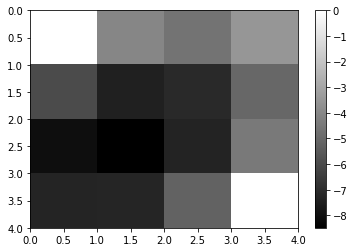

In [21]:
def plot_gridworld_value(V):
    plt.figure()
    c = plt.pcolormesh(V, cmap='gray')
    plt.colorbar(c)
    plt.gca().invert_yaxis()  # In the array, first row = 0 is on top

# Making a plot always helps
plot_gridworld_value(V.reshape(env.shape))

In [22]:
# Test: When you hand in the nodebook we will check that the value function is (approximately) what we expected
# but we need to make sure it is at least of the correct shape
v = policy_eval(random_policy, env)
assert v.shape == (env.nS)

---
## 2. Policy Iteration (2 points)
Using the policy evaluation algorithm we can implement policy iteration to find a good policy for this problem. Note that we do not need to use a discount_factor for episodic tasks but make sure your implementation can handle this correctly!

In [18]:
def get_action_values(s, env, state_values, discount_factor=1.0):
    """
    Helper function used to look for the best action from state s.
    It returns the action values, and those can be subsequently
    used to determine the best action.
    :param s: the state for which we want to compute the action values
    :param env: The OpenAI Gym environment:
                 - env.P - transition probabilities of the environment
                 - env.P[state][action] - a list of transition tuples
                 - env.observation_space.n - number of states
                 - env.action_space.n - number of actions
    :param state_values: the state values used in updating the policy
    :param discount_factor: gamma the discount factor
    :return: the action values
    """
    action_vals = np.zeros(len(env.P[s]))
    for a in env.P[s].keys():
        for prob, next_state, reward, _ in env.P[s][a]:
            action_vals[a] += prob * (reward + discount_factor * state_values[next_state])
    return action_vals

def actual_policy_improvement(env, policy, state_values, discount_factor=1.0):
    """
    Improves the policy based on the state values calculated using policy evaluation.
    :param env: The OpenAI Gym environment:
                 - env.P - transition probabilities of the environment
                 - env.P[state][action] - a list of transition tuples
                 - env.observation_space.n - number of states
                 - env.action_space.n - number of actions
    :param policy: the policy to be evaluated
    :param state_values: the state values used in updating the policy
    :param discount_factor: gamma the discount factor
    :return: True if the policy is stable, and False otherwise.
    """
    # we assume that the policy is stable
    policy_stable = True
    # loop over each state
    for state in env.P.keys():
        # get the previous best action
        old_best_action = np.argmax(policy[state])
        # compute action values
        action_values = get_action_values(state, env, state_values, discount_factor)
        # get the new best action
        new_best_action = np.argmax(action_values)
        if old_best_action != new_best_action:
            # if the actions are different, then the policy isn't stable
            policy_stable = False
        # update the policy of the state
        policy[state] = np.eye(len(env.P[state]))[new_best_action]
    return policy_stable

def policy_improvement(env, discount_factor=1.0):
    """
    Performs policy iteration by performing policy evaluation, then policy iteration
    sequentially until the policy does not change anymore.
    :param env: The OpenAI Gym environment
    :param policy: the policy to be evaluated (if None, initialize an equidistant policy)
    :param discount_factor: gamma the discount factor
    :param theta: we stop iterating once the state value changes are less than theta
    :return: the policy and the state values
    """
    theta=0.00001
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    state_values = None
    policy_stable = False
    # iterate while the policy isn't stable
    while policy_stable is False:
        # perform policy evaluation
        state_values = policy_eval(policy, env, discount_factor, theta)
        # perform policy iteration
        policy_stable = actual_policy_improvement(env, policy, state_values, discount_factor)
    return policy, state_values



Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 1 0]
 [0 0 0 0]
 [0 0 1 2]
 [0 1 1 0]]
^<>^
^^^^
^^>v
^>>^

Value Function:
[ 0. -1. -2. -1. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -1.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



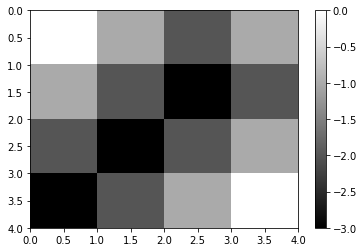

In [24]:
# Let's see what it does
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

def print_grid_policy(policy, symbols=["^", ">", "v", "<"]):
    symbols = np.array(symbols)
    for row in policy:
        print("".join(symbols[row]))

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

plot_gridworld_value(v.reshape(env.shape))

In [ ]:
# This is not an empty cell. It is needed for grading.

---
## 3. Value Iteration (3 points)
Now implement the value iteration algorithm.

In [53]:

def value_iteration(env, theta=0.00001, discount_factor=1.0):
    """
    Performs value iteration algorithm as described in the Sutton and Barto book.
    :param env: The OpenAI Gym environment:
                 - env.P - transition probabilities of the environment
                 - env.P[state][action] - a list of transition tuples
                 - env.observation_space.n - number of states
                 - env.action_space.n - number of actions
    :param discount_factor: gamma the discount factor
    :param theta: we stop iterating once the state value changes are less than theta
    :return:
    """
    # initialize the state values
    state_values = np.zeros(env.observation_space.n, dtype=np.float64)    
    # initialize delta check
    delta = theta + 1.0
    while delta > theta:
        delta = 0
        # loop over all the states
        for state in env.P.keys():
            # get the action values
            action_values = get_action_values(state, env, state_values)
            # get the best action value
            best_action_value = np.max(action_values)
            # update delta
            delta = np.max((delta, np.abs(best_action_value - state_values[state])))
            # update state value
            state_values[state] = best_action_value
    # initialize the policy
    policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
    # loop over each state
    for state in env.P.keys():
        # compute action values
        action_values = get_action_values(state, env, state_values, discount_factor)
        # get the best action
        best_action = np.argmax(action_values)
        # update policy
        policy[state] = np.eye(len(env.P[state]))[best_action]
    # list is expected
    policy_list = [list(poli) for poli in policy.values()]

    return policy_list, state_values


In [54]:
# Oh let's test again
# Let's see what it does
policy, v = value_iteration(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")


Policy Probability Distribution:
[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



What is the difference between value iteration and policy iteration? Which algorithm is most efficient (e.g. needs to perform the least *backup* operations)? Please answer *concisely* in the cell below.

Value iteration only performs one sweep of policy evaluation in each step, whereas policy iteration conducts a full (up to convergence) policy evaluation in each step of the iteration (evaluation + improvement). Furthermore, value iteration combines evaluation and improvement, and therefore performs the backup operation in each step. To be more precise, policy iteration assesses the current policy by computing the expected value for every state. Only then, the policy is updated by the newly obtained value estimates. Value iteration on the other side does not require to sweep all states to find the best policy change, but directly computes policy changes according to the best return obtained among all the possible action choices for each state.

Value iteration is more efficient, as only performing one sweep of policy evaluation before updating the policy yields less backup operations. 




## 4. Monte Carlo Prediction (7 points)
What is the difference between Dynamic Programming and Monte Carlo? When would you use the one or the other algorithm?

For the Monte Carlo Prediction we will look at the Blackjack game (Example 5.1 from the book), for which the `BlackjackEnv` is implemented in `blackjack.py`. Note that compared to the gridworld, the state is no longer a single integer, which is why we use a dictionary to represent the value function instead of a numpy array. By using `defaultdict`, each state gets a default value of 0.

In [55]:
from blackjack import BlackjackEnv
env = BlackjackEnv()

For the Monte Carlo algorithm, we need to *interact* with the environment. This means that we start an episode by using `env.reset` and send the environment actions via `env.step` to observe the reward and next observation (state).

In [56]:
# So let's have a look at what we can do in general with an environment...
import gym
?gym.Env

In [78]:
# We can also look at the documentation/implementation of a method
?env.step

In [69]:
??BlackjackEnv

A very simple policy for Blackjack is to *stick* if we have 20 or 21 points and *hit* otherwise. We want to know how good this policy is. This policy is *deterministic* and therefore a function that maps an observation to a single action. Technically, we can implement this as a dictionary or as a function, where we use the latter. To get started, let's implement this simple policy for BlackJack.

In [128]:
def simple_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    return int(observation[0] < 20)

def blackjack_policy(observation):
    """
    Makes a Blackjack policy that sticks
    if the player score is >= 20and hits otherwise.
    :param observation: the state of the game
    """
    score, _, _ = observation
    return [1.0, 0.0] if score >= 20 else [0.0, 1.0]

In [131]:
s = env.reset()
print(s)
a = simple_policy(s)
print(env.step(a))

(15, 10, False)
((25, 10, False), -1, True, {})


Now implement either the MC prediction algorithm (either first visit or every visit). Hint: you can use `for i in tqdm(range(num_episodes))` to show a progress bar.

In [232]:
from collections import defaultdict

def generate_episode(env, policy):
    """
    Generates an episode of the environment given the policy
    :param env: the OpenAI Gym environment
    :param policy: the policy used to generate the episode
    :return: the episode list
    """
    # initialize episode list
    episode = []
    # reset the environment and get the state
    state = env.reset()
    # initialize done boolean
    done = False
    # loop while the episode isn't finished
    while not done:
              
        action = policy(state)
        # take the action
        next_state, reward, done, _ = env.step(action)
        # append the results to the episode list
        episode.append((state, action, reward))
        # break if the episode is finished
        if done:
            break
        state = next_state
    return episode

def generate_episode_prob(env, policy):
    """
    Generates an episode of the environment given the policy
    :param env: the OpenAI Gym environment
    :param policy: the policy used to generate the episode
    :return: the episode list
    """
    # initialize episode list
    episode = []
    # reset the environment and get the state
    state = env.reset()
    # initialize done boolean
    done = False
    # loop while the episode isn't finished
    while not done:
        # get the action given the policy
        if type(policy) is defaultdict or type(policy) is dict:
            action_prob = policy[state]
        else:
            action_prob = policy(state)
        action = np.random.choice(np.arange(len(action_prob)), p=action_prob)
        # take the action
        next_state, reward, done, _ = env.step(action)
        # append the results to the episode list
        episode.append((state, action, reward))
        # break if the episode is finished
        if done:
            break
        state = next_state
    return episode

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo Prediction algorithm as described in Sutton and Barto 5.1
    The algorithm calculates the state value functions by sampling a given
    number of episodes using the given policy.
    :param env: OpenAI gym environment
    :param no_episodes: how many episodes we sample
    :param policy: the policy used to sample episodes
    :param discount_factor: the gamma discount factor
    :return: the state value function
    """

    # initialize returns dictionaries
    sum_returns = defaultdict(float)
    count_returns = defaultdict(float)
    # initialize the state values
    state_values = defaultdict(float)
    # start looping over episodes
    for _ in tqdm(range(num_episodes)):
        # generate the episode
        episode = generate_episode(env, policy)
        # set of states that were seen in the episode
        states_in_ep = set([obs[0] for obs in episode])
        for state in states_in_ep:
            # determine the first occurrence of the state in the episode
            first_occurrence = [t for t, obs in enumerate(episode) if obs[0] == state][0]
            # calculate G
            g = np.sum([obs[2] * np.power(discount_factor, t)
                        for t, obs in enumerate(episode[first_occurrence:])])
            # update returns
            sum_returns[state] += g
            count_returns[state] += 1.0
            # update state value
            state_values[state] = sum_returns[state] / count_returns[state]
    return state_values


In [163]:
V = mc_prediction(simple_policy, env, num_episodes=1000)
print(V)

100%|████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6756.57it/s]


defaultdict(<class 'float'>, {(21, 6, True): 1.0, (14, 8, False): -0.5555555555555556, (21, 8, False): 1.0, (12, 8, False): -0.6923076923076923, (20, 4, False): 0.625, (15, 7, False): -0.6, (16, 10, False): -0.5609756097560976, (14, 10, False): -0.6590909090909091, (15, 10, False): -0.5454545454545454, (17, 8, False): -1.0, (19, 8, False): -1.0, (21, 10, True): 0.7, (14, 4, False): -0.8181818181818182, (20, 7, False): 0.9, (17, 5, False): -0.8333333333333334, (19, 10, False): -0.6595744680851063, (17, 10, False): -0.6470588235294118, (18, 10, False): -0.68, (20, 10, False): 0.23636363636363636, (13, 10, False): -0.5806451612903226, (13, 8, False): -0.5, (20, 8, False): 0.9333333333333333, (21, 10, False): 0.868421052631579, (19, 7, False): -1.0, (19, 1, False): -1.0, (18, 1, False): -0.5384615384615384, (15, 3, False): -0.6666666666666666, (13, 6, False): -0.23076923076923078, (14, 2, False): -1.0, (12, 2, False): -0.75, (17, 2, False): -0.7692307692307693, (12, 7, False): -0.166666666

Now make *4 plots* like Figure 5.1 in the book. You can either make 3D plots or heatmaps. Make sure that your results look similar to the results in the book. Give your plots appropriate titles, axis labels, etc.

In [191]:
%%time
# Let's run your code one time
V_10k = mc_prediction(simple_policy, env, num_episodes=10000)
V_500k = mc_prediction(simple_policy, env, num_episodes=500000)

100%|███████████████████████████████████████████| 500000/500000 [00:36<00:00, 13694.88it/s]


Wall time: 37.3 s


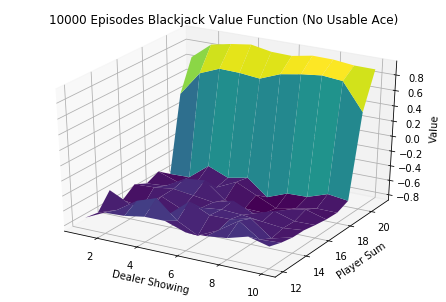

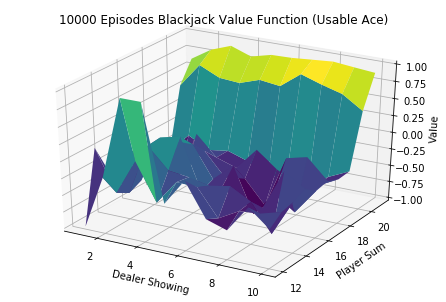

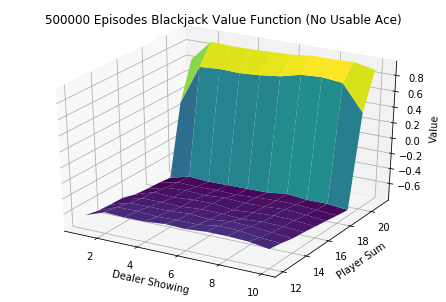

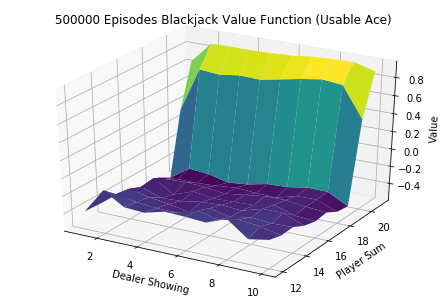

In [196]:
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_value_function_blackjack(state_values, title):
    """
    Plots the value function of a Blackjack solution as a surface plot.
    :param state_values: state values of the Blackjack game.
    :param title: title of the plot
    """
    x_states = [s[1] for s in state_values.keys()]
    y_states = [s[0] for s in state_values.keys()]
    min_x = np.min(x_states)
    max_x = np.max(x_states)
    min_y = np.min(y_states)
    max_y = np.max(y_states)

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    x_grid, y_grid = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    z_no_ace = np.apply_along_axis(lambda _: state_values[(_[1], _[0], False)],
                                   2, np.dstack([x_grid, y_grid]))
    z_ace = np.apply_along_axis(lambda _: state_values[(_[1], _[0], True)],
                                2, np.dstack([x_grid, y_grid]))

    def plot_surface(x, y, z, plot_title):
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.plot_surface(x, y, z, rstride=1, cstride=1,
                        cmap='viridis')
        ax.set_ylabel('Player Sum')
        ax.set_xlabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(plot_title)
        plt.show()

    plot_surface(x_grid, y_grid, z_no_ace, "{} (No Usable Ace)".format(title))
    plot_surface(x_grid, y_grid, z_ace, "{} (Usable Ace)".format(title))

plot_value_function_blackjack(V_10k, '{} Episodes Blackjack Value Function'.format(10000))
plot_value_function_blackjack(V_500k, '{} Episodes Blackjack Value Function'.format(500000))


## 5. Monte Carlo control with $\epsilon$-greedy policy (5 points)
Now we have a method to evaluate state-values given a policy. Take a moment to think whether we can use the value function to find a better policy? Assuming we do not know the dynamics of the environment, why is this not possible?

We want a policy that selects _actions_ with maximum value, e.g. is _greedy_ with respect to the _action-value_ (or Q-value) function $Q(s,a)$. We need to keep exploring, so with probability $\epsilon$ we will take a random action. First, lets implement a function `make_epsilon_greedy_policy` that takes the Q-value function and returns an $\epsilon$-greedy policy. The policy itself is a function that returns an action.

In [244]:
def make_epsilon_greedy_policy(q, epsilon, action_count):
    """
    This function creates an epsilon greedy policy based on the given Q.
    :param action_count: Number of actions
    :param epsilon: Probability to select a random action
    :param q: A dictionary that maps from a state to the action values
              for all possible nA actions (represented as an array)
   
    :return: A function that takes as argument an observation and returns
             the probabilities of each action.
    """

    def policy_func(observation, eps=epsilon):
        actions = np.ones(action_count, dtype=float) * eps / action_count
        
        q_values = q[observation]
        
        best_action = np.argmax(q_values)
        actions[best_action] += (1.0 - eps)
        
        return actions

    return policy_func


In [247]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    On-policy first-visit Monte Carlo Control with epsilon greedy policies,
    as described in section 5.4 of Sutton and Barto.
    Finds an optimal epsilon greedy policy for the given environment and
    returns and policy and the q function.
    :param env: the OpenAI Gym environment
    :param num_episodes: how many episodes we sample
    :param epsilon: epsilon value for the greedy policies
    :param discount_factor: the gamma discount factor
    :return: the q function and the optimal epsilon greedy policy
    """
    # initialize returns dictionaries
    sum_returns = defaultdict(float)
    count_returns = defaultdict(float)
    # initialize the q function
    q = defaultdict(lambda: np.zeros(env.action_space.n))
    # initialize the epsilon greedy policy
    policy = make_epsilon_greedy_policy(q, epsilon, env.action_space.n)
    # start looping over episodes
    for _ in tqdm(range(num_episodes)):
        # generate the episode
        episode = generate_episode_prob(env, policy)
        # set of state action tuples that were seen in the episode
        sa_tuples_in_ep = set([(obs[0], obs[1]) for obs in episode])
        for state, action in sa_tuples_in_ep:
            # determine the first occurrence of the state action tuple in the episode
            first_occurrence = [t for t, obs in enumerate(episode)
                                if obs[0] == state and obs[1] == action][0]
            # calculate G
            g = np.sum([obs[2] * np.power(discount_factor, t)
                        for t, obs in enumerate(episode[first_occurrence:])])
            # update returns
            pair = (state, action)
            sum_returns[pair] += g
            count_returns[pair] += 1.0
            # update q function
            q[state][action] = sum_returns[pair] / count_returns[pair]
        # update policy after the episode
        policy = make_epsilon_greedy_policy(q, epsilon, env.action_space.n)
    return q, policy

# Test it quickly
Q_10k, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)

100%|██████████████████████████████████████████████| 10000/10000 [00:01<00:00, 7645.23it/s]


In [263]:
%%time
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

100%|████████████████████████████████████████████| 500000/500000 [01:09<00:00, 7176.66it/s]


Wall time: 1min 9s


How can you obtain the (V-)value function from the Q-value function? Plot the (V-)value function that is the result of 500K iterations. Additionally, visualize the greedy policy similar to Figure 5.2 in the book. Use a white square for hitting, black for sticking.

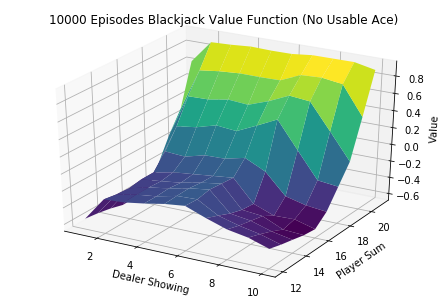

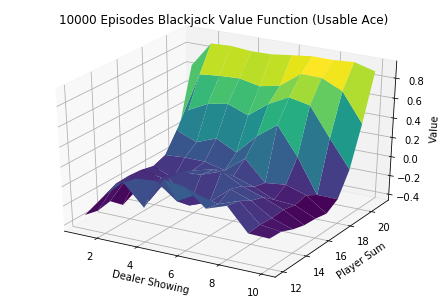

In [264]:
def create_state_value_function(q):
    """
    Creates a state value function from a q function.
    :param q: the q function
    :return: the state value function
    """
    state_values = defaultdict(float)
    for state, action_values in q.items():
        state_values[state] = np.max(action_values)
    return state_values


V_10k = create_state_value_function(Q_10k)
#plot_value_function_blackjack(V_10k, '{} Episodes Blackjack Value Function'.format(10000))

V = create_state_value_function(Q)
plot_value_function_blackjack(V, '{} Episodes Blackjack Value Function'.format(10000))



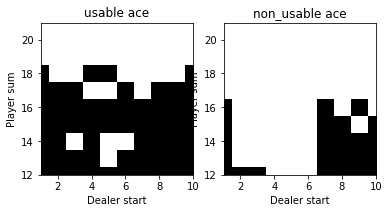

In [271]:
def plot_blackjack_policy(V, policy):
    # initialize empty matrix with 21/10 for sum_player/start_dealer field
    usable_matrix = np.zeros((22, 11), dtype=int)
    non_usable_matrix = np.zeros((22, 11), dtype=int)

    # iterate through states and divide into usable/non_usable mat by filling with the 
    # max probability according to the policy at the state
    for state in V.keys():
        sum_player, dealer_start, ace = state
        if ace:
            tmp_mat = usable_matrix
        else: 
            tmp_mat = non_usable_matrix
        # fill margmax action into respective matrix
        tmp_mat[sum_player, dealer_start] = np.argmax(policy(state))
    
    def plot_one_policy(matrix, title):
        # plot matrix (0,1)-values -> therefore black/white tiles
        plt.imshow(matrix, cmap='Greys')
        plt.title(title)
        plt.ylabel('Player sum')
        plt.ylim((12, 21))
        plt.xlabel('Dealer start')
        plt.xlim((1, 10))
        
    plt.subplot(121)  
    plot_one_policy(usable_matrix, "usable ace")
    plt.subplot(122)  
    plot_one_policy(non_usable_matrix, "non_usable ace")
    plt.show()
    
# plot 
plot_blackjack_policy(V, policy)
